In [125]:
#importing numpy and pandas
import pandas as pd
import numpy as np

In [126]:
#importing libraries for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [127]:
#importing other files
import nltk
import string
import re
import sys
import warnings
#importing wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [128]:
#importing libraries for forming word matrix using TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer


In [129]:
#importing library for calculating logisitic regression for our formed word matrix
from sklearn.linear_model import LogisticRegression

In [130]:
#importing joblib for creating pickle file
from sklearn.externals import joblib 

/home/anmol/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [131]:
#importing other libraries 
from sklearn.pipeline import make_union
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

In [132]:
#supressing future warnings
from warnings import simplefilter
simplefilter(action='ignore',category=FutureWarning)

In [133]:
df_train = pd.read_csv('/home/anmol/iiitb-toxic-comment/train.csv')

In [134]:
df_train.head()

id                                       comment_text  toxic  \
0  4a16050093a99092                No, you have to prove that I can't.      0   
1  6bc2122dc27e275a  Re: My major edit summaries \n\nI have receive...      0   
2  5570f7207bade92f  I depersonalized it. It's sad how you don't ob...      0   
3  a17d6408ffb98139  Thats because I was blocked before I could dis...      0   
4  11b1d25d77ffd834  I apologise for this, I was just angry with ha...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

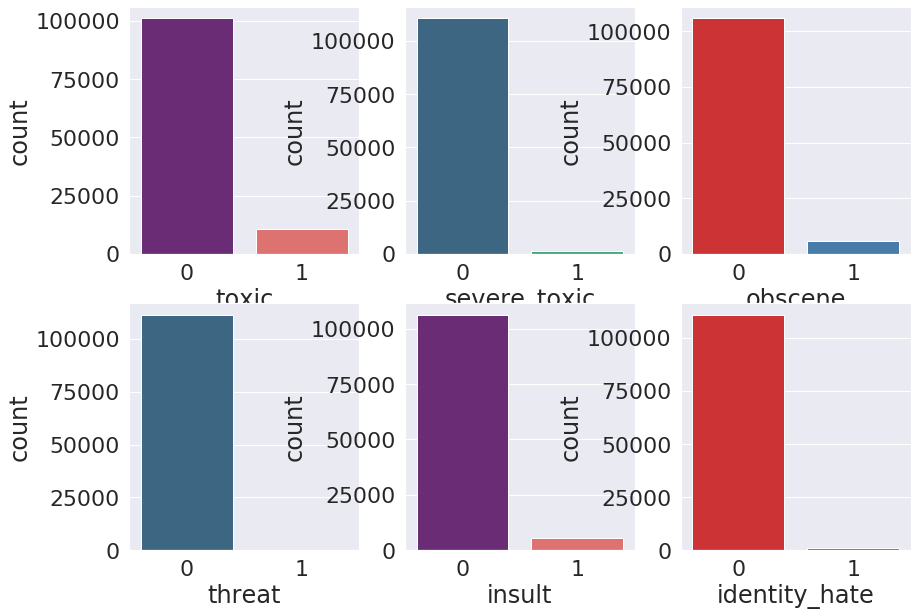

In [138]:
#plotting countplot graph for all the categories of comments classified
fig,ax = plt.subplots(2,3,figsize=(14,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(df_train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(df_train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(df_train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(df_train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(df_train['insult'], palette = 'magma',ax=ax5)
sns.countplot(df_train['identity_hate'], palette = 'Set1', ax = ax6)

Text(0, 0.5, 'Occurrence')

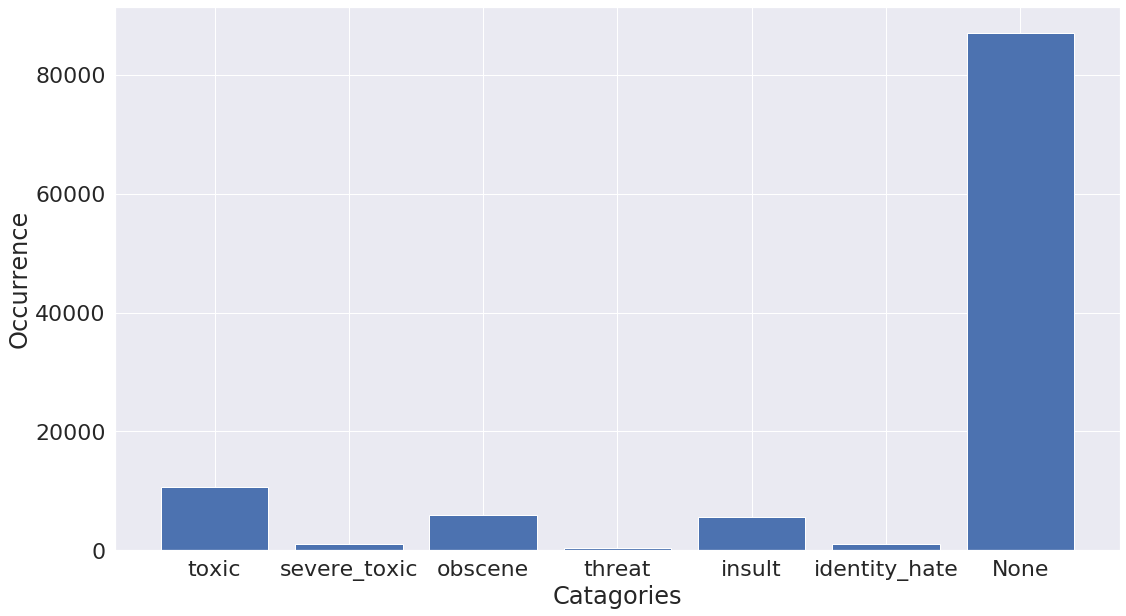

In [139]:
#plotting occurace graph for comparing toxic comments in all the catoegory along what all are not toxic 
col_names = df_train.columns.values[2:]
col_names = col_names.tolist()
col_names.append('None')
x = [sum(df_train[y]) for y in df_train.columns.values[2:]]
x.append(len(df_train) - sum(x))
plt.figure(figsize = (18, 10))
plt.bar(np.arange(len(x)),x)
plt.xticks(np.arange(len(x)), col_names)
plt.xlabel('Catagories')
plt.ylabel('Occurrence')

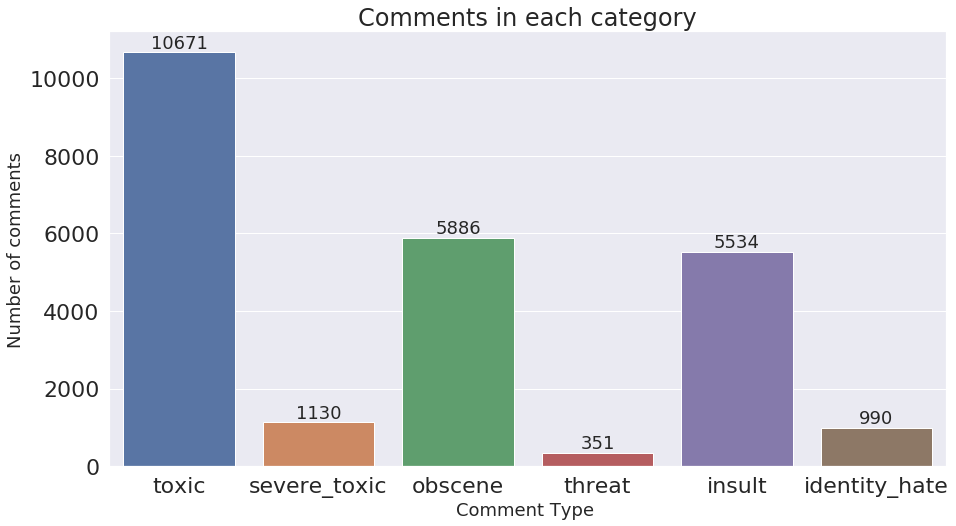

In [140]:
#plotting graph for comment types v/s number of comments
categories = list(df_train.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories[2:], df_train.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()


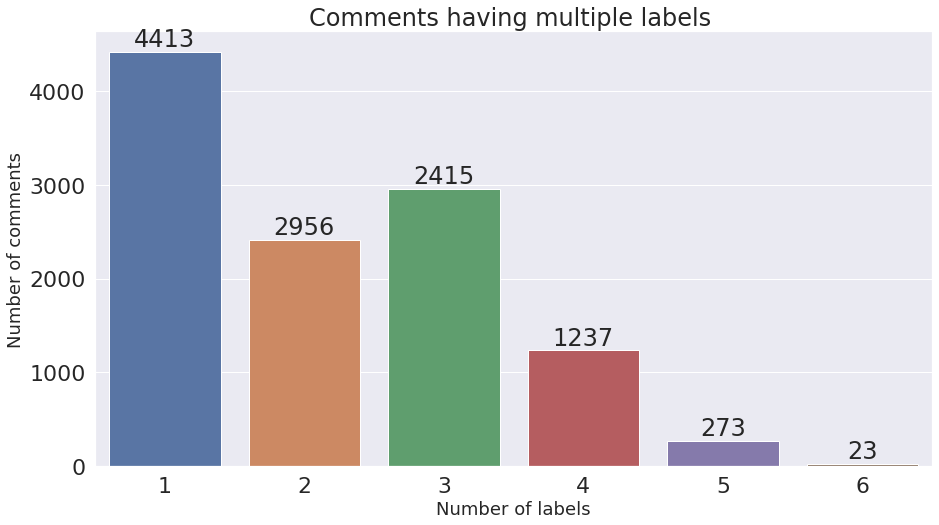

In [141]:
#plotting graph for number of comments v/s number of labels they belong to
rowSums = df_train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [142]:
#converting our given training dataset to Lowercase  
df_train['comment_text'] = df_train['comment_text'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex = True)

In [147]:
#removing all the puncuations
import re
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned 

In [148]:
df_train.head()

id                                       comment_text  toxic  \
0  4a16050093a99092                no  you have to prove that i can t       0   
1  6bc2122dc27e275a  re  my major edit summaries   i have received ...      0   
2  5570f7207bade92f  i depersonalized it  it s sad how you don t ob...      0   
3  a17d6408ffb98139  thats because i was blocked before i could dis...      0   
4  11b1d25d77ffd834  i apologise for this  i was just angry with ha...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [149]:
#creating word matrix for our given training dataset
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    stop_words='english',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=30000)

In [150]:
#creating char matrix for our given training dataset
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    stop_words = 'english',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

In [151]:
vectorizer = make_union(word_vectorizer,char_vectorizer)

In [152]:
df_test = pd.read_csv('/home/anmol/iiitb-toxic-comment/test.csv')

In [153]:
#converting our given test dataset to Lowercase
df_test['comment_text'] = df_test['comment_text'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex = True)

train_comments = df_train['comment_text']
test_comments = df_test['comment_text']

In [154]:
#removing all the puncuations
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [155]:
#applying the vectorizer on the comment
vectorizer.fit(train_comments)

FeatureUnion(n_jobs=None,
             transformer_list=[('tfidfvectorizer-1',
                                TfidfVectorizer(analyzer='word', binary=False,
                                                decode_error='strict',
                                                dtype=<class 'numpy.float64'>,
                                                encoding='utf-8',
                                                input='content', lowercase=True,
                                                max_df=1.0, max_features=30000,
                                                min_df=1, ngram_range=(1, 2),
                                                norm='l2', preprocessor=None,
                                                smooth_idf=True,
                                                stop_words='english',
                                                strip_accents='unico...
                                                dtype=<class 'numpy.float64'>,
                       

In [ ]:

train_features = vectorizer.transform(train_comments)
test_features = vectorizer.transform(test_comments)

In [93]:
submission = pd.DataFrame.from_dict({'id': df_test['id']})

In [94]:
#creating function for displaying the wordcloud
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
def clean(s): return re_tok.sub(r' \1 ', s)
def prepare_text(text_col):
    ## decide vocab size
    text = text_col
    words = []
    for t in text:
        words.extend(tokenize(t))
    ##print(words[:100])
    vocab = list(set(words))
    ##print(len(words), len(vocab))
    words_str1 = ' '.join(str(e) for e in words)  
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(stopwords=STOPWORDS,
                              collocations=False,
                              width=2500,
                              height=1800, background_color="white").generate(words_str1)
    plt.figure(figsize=(30,50))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

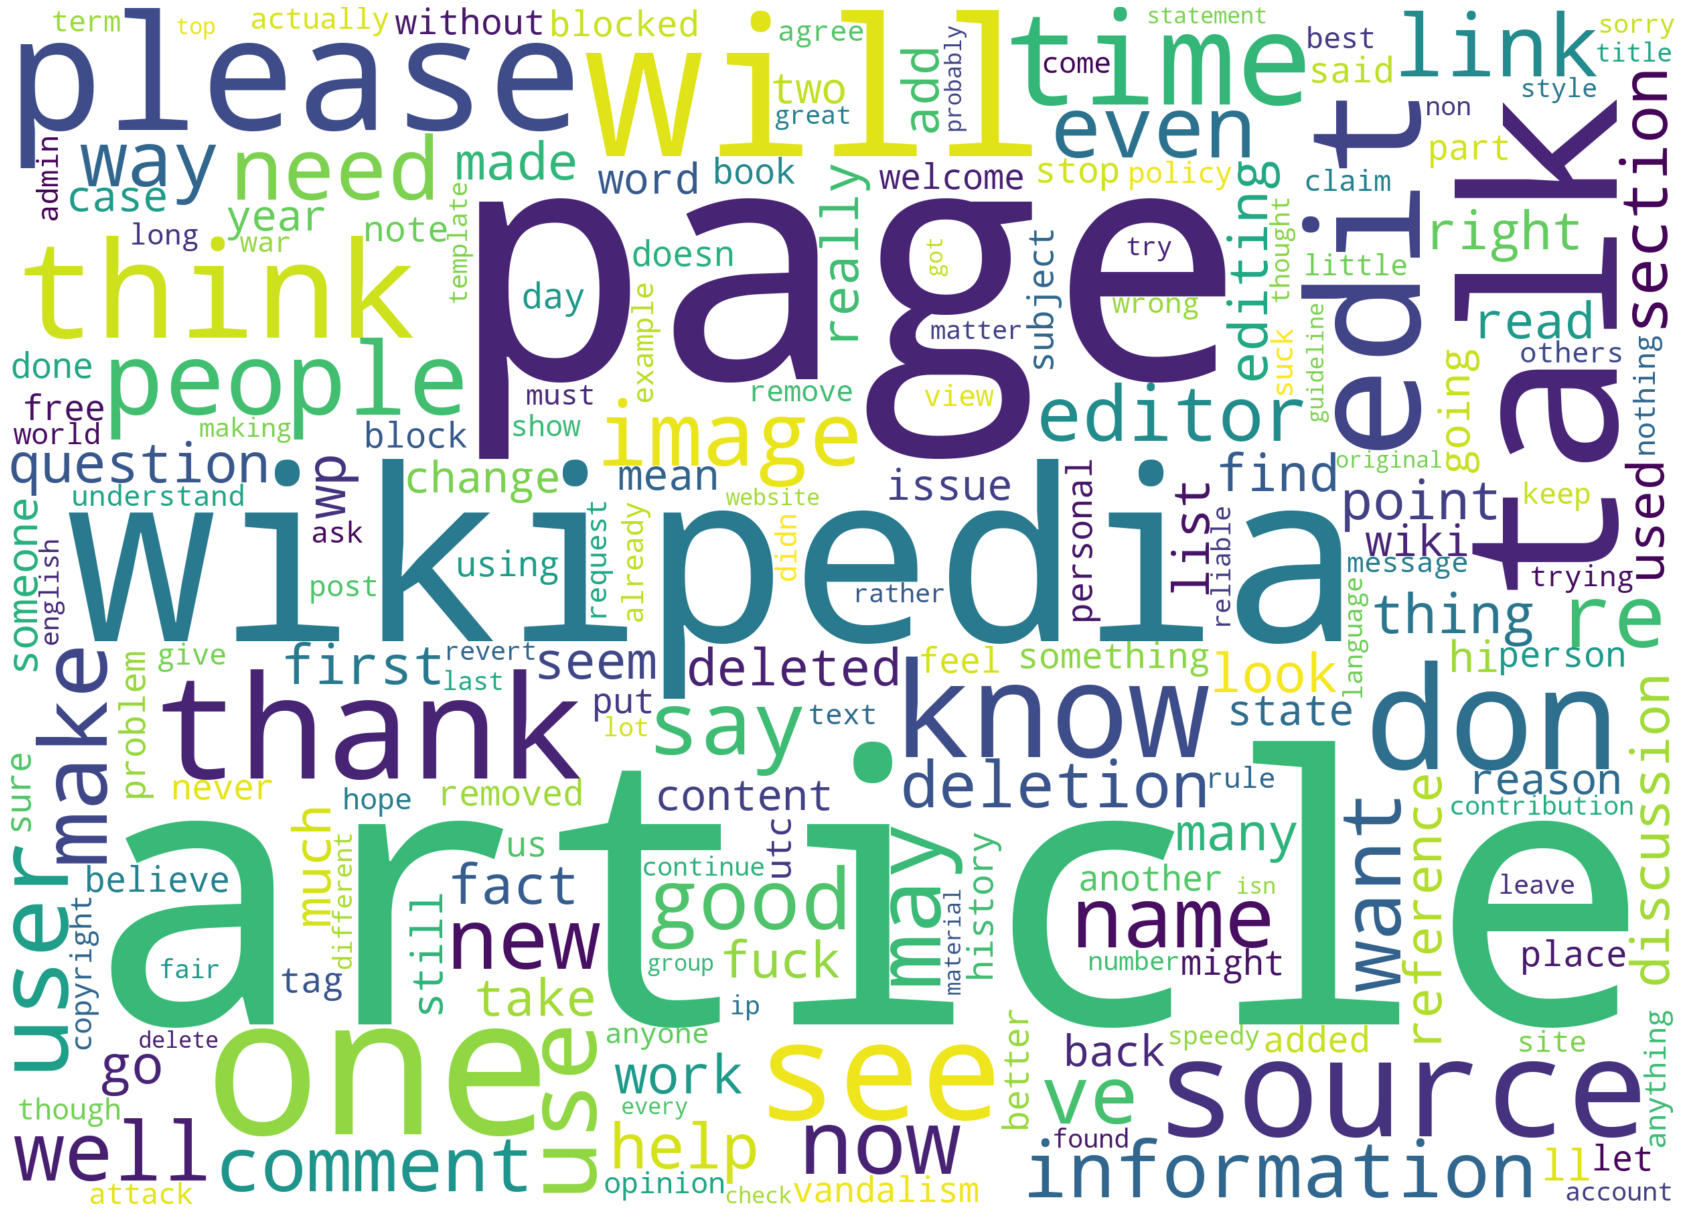

In [95]:
#wordcloud for comment_text 
prepare_text(df_train['comment_text'])

In [68]:
#categorising words based on the target column of the commments specified for displaying wordcloud
toxic_comments = df_train.loc[df_train.toxic != 0]['comment_text']
severe_toxic_comments = df_train.loc[df_train.severe_toxic != 0]['comment_text']
obscene_comments = df_train.loc[df_train.obscene != 0]['comment_text']
threat_comments = df_train.loc[df_train.threat != 0]['comment_text']
insult_comments = df_train.loc[df_train.insult != 0]['comment_text']
identity_hate_comments = df_train.loc[df_train.identity_hate != 0]['comment_text']

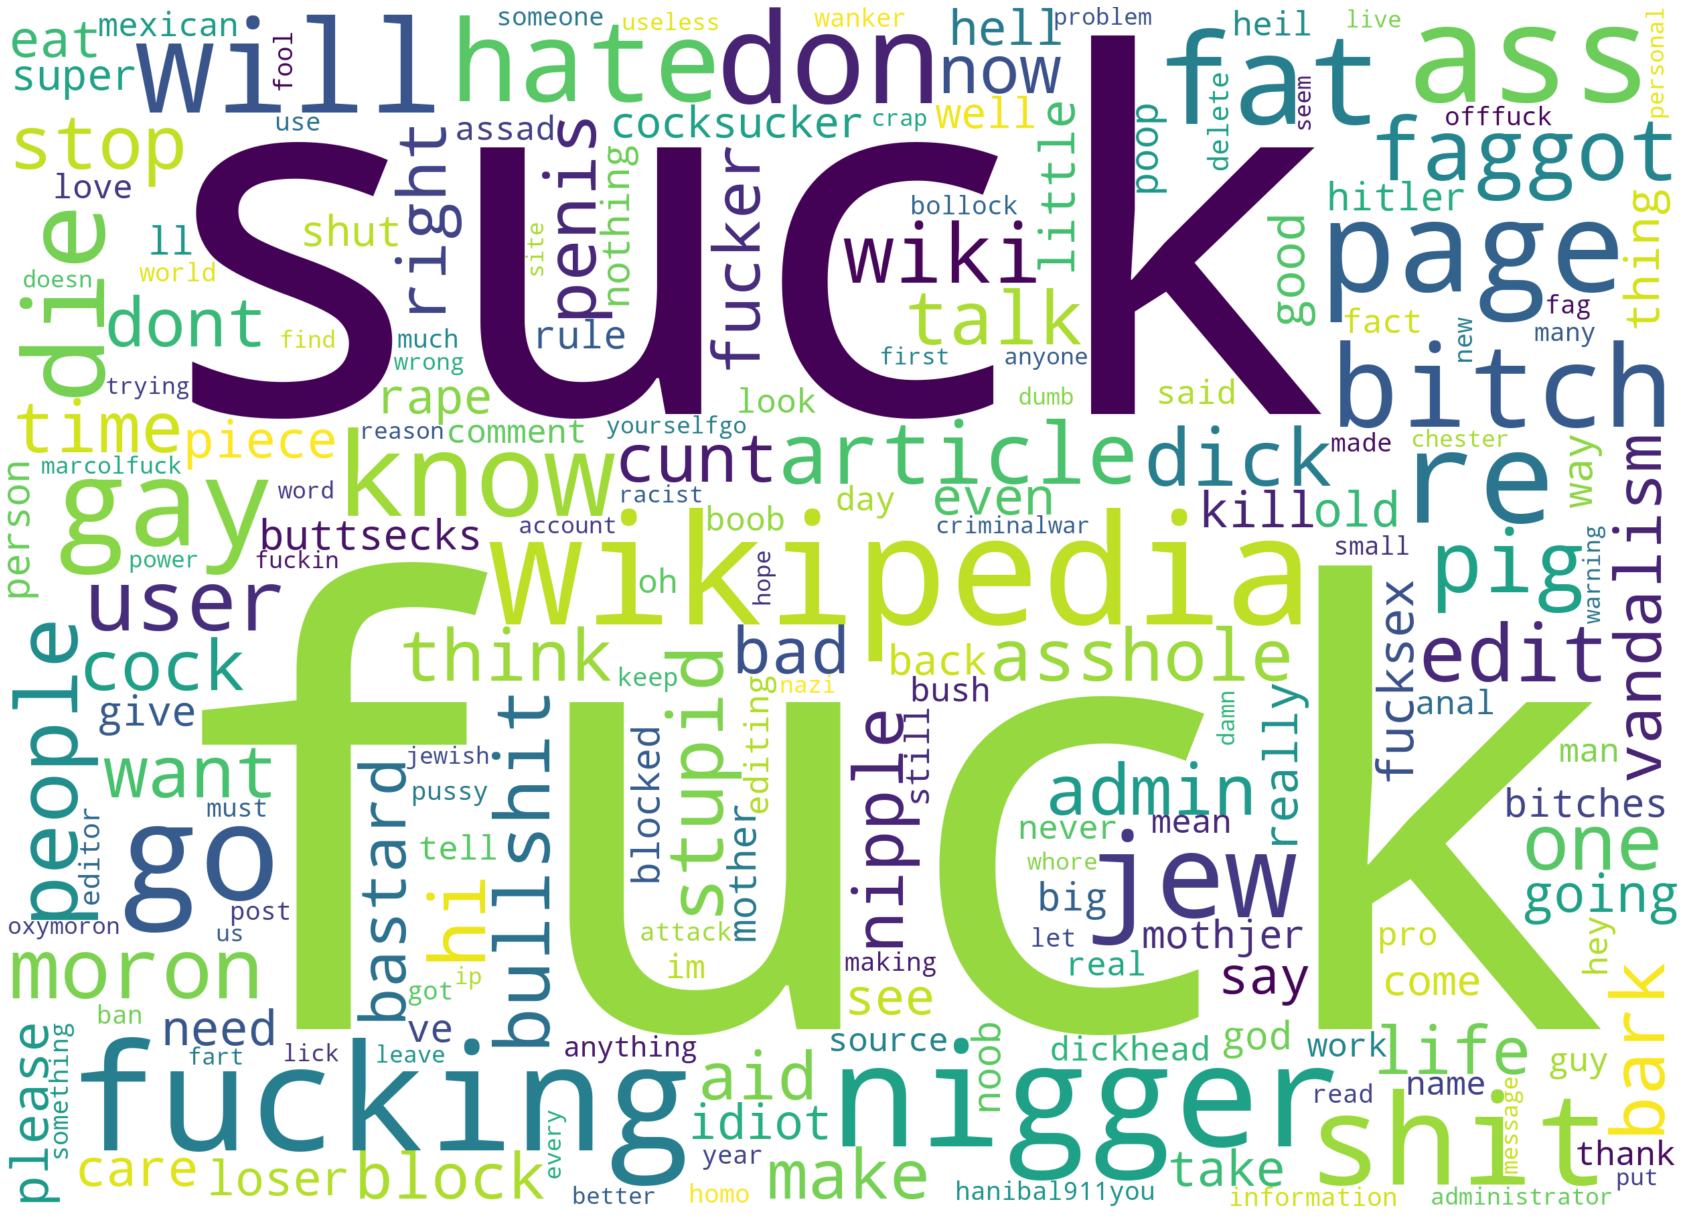

In [69]:
prepare_text(toxic_comments)

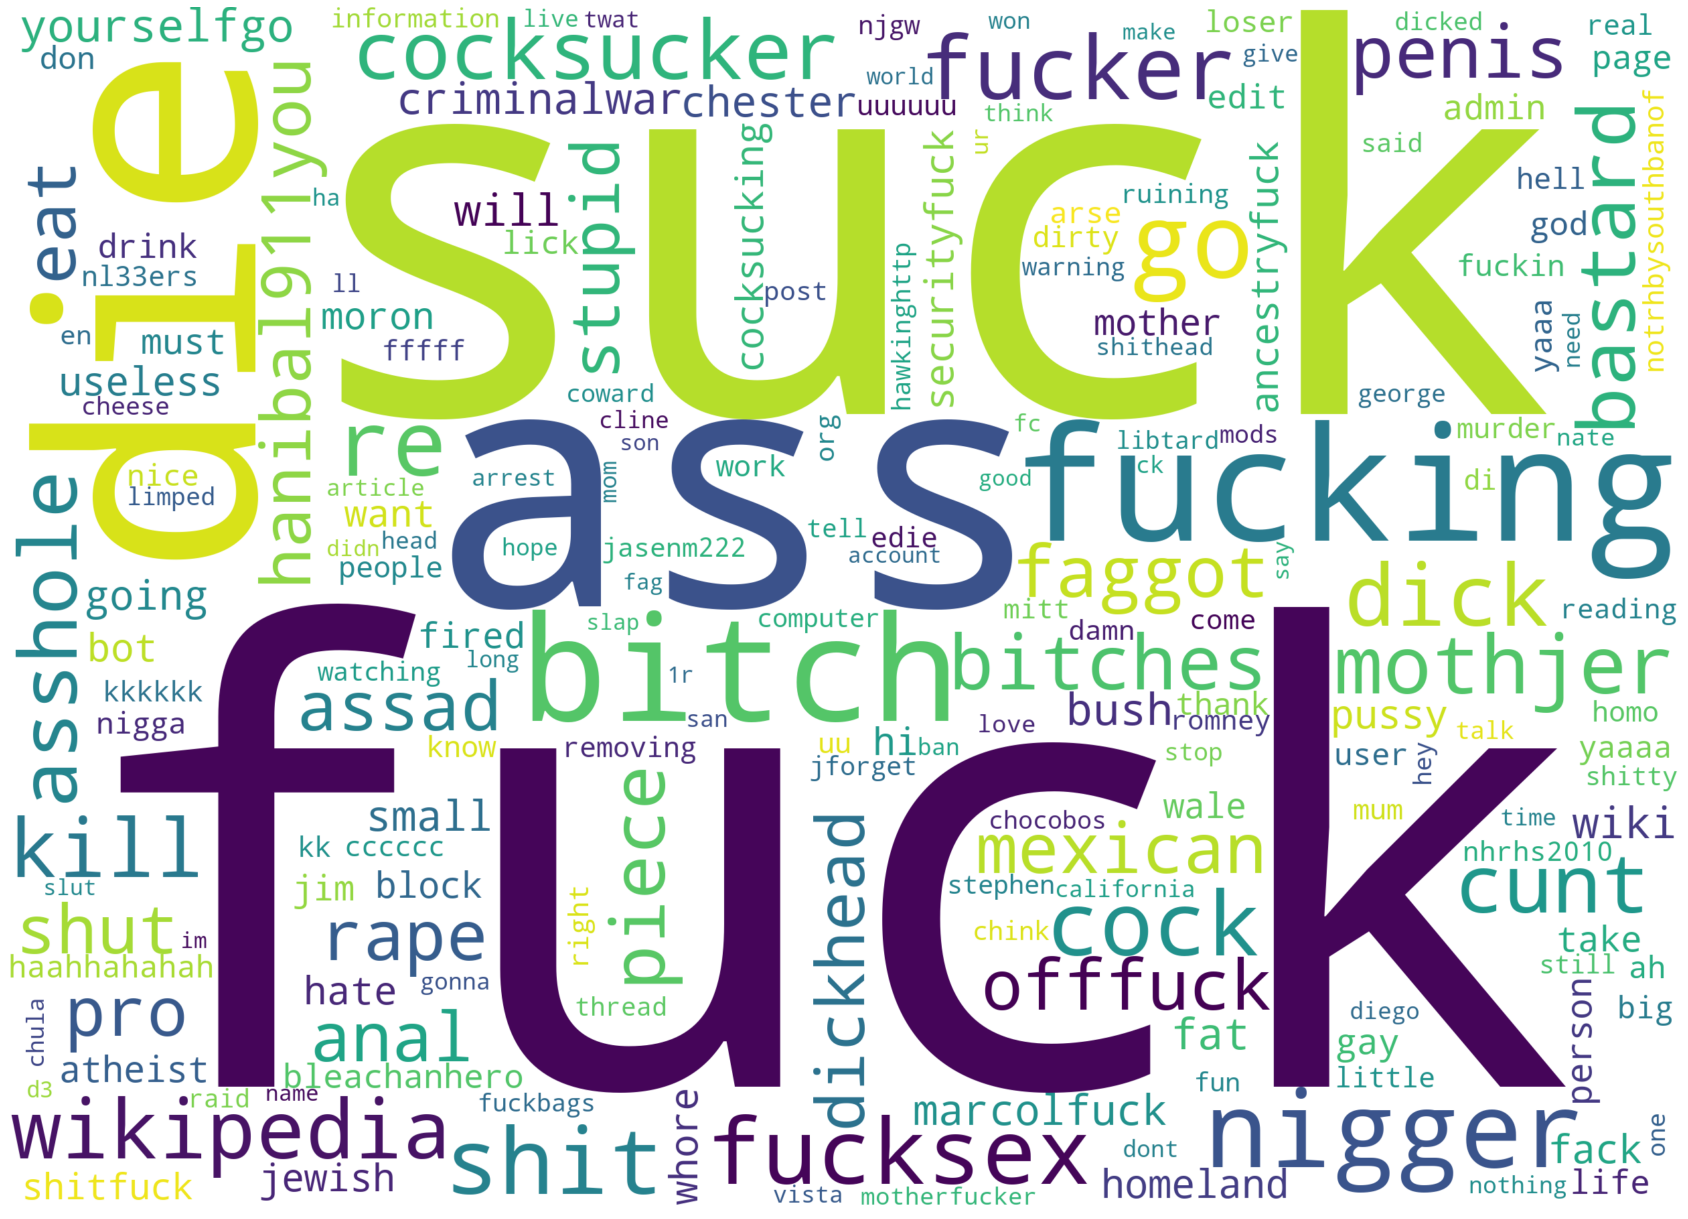

In [70]:
prepare_text(severe_toxic_comments)

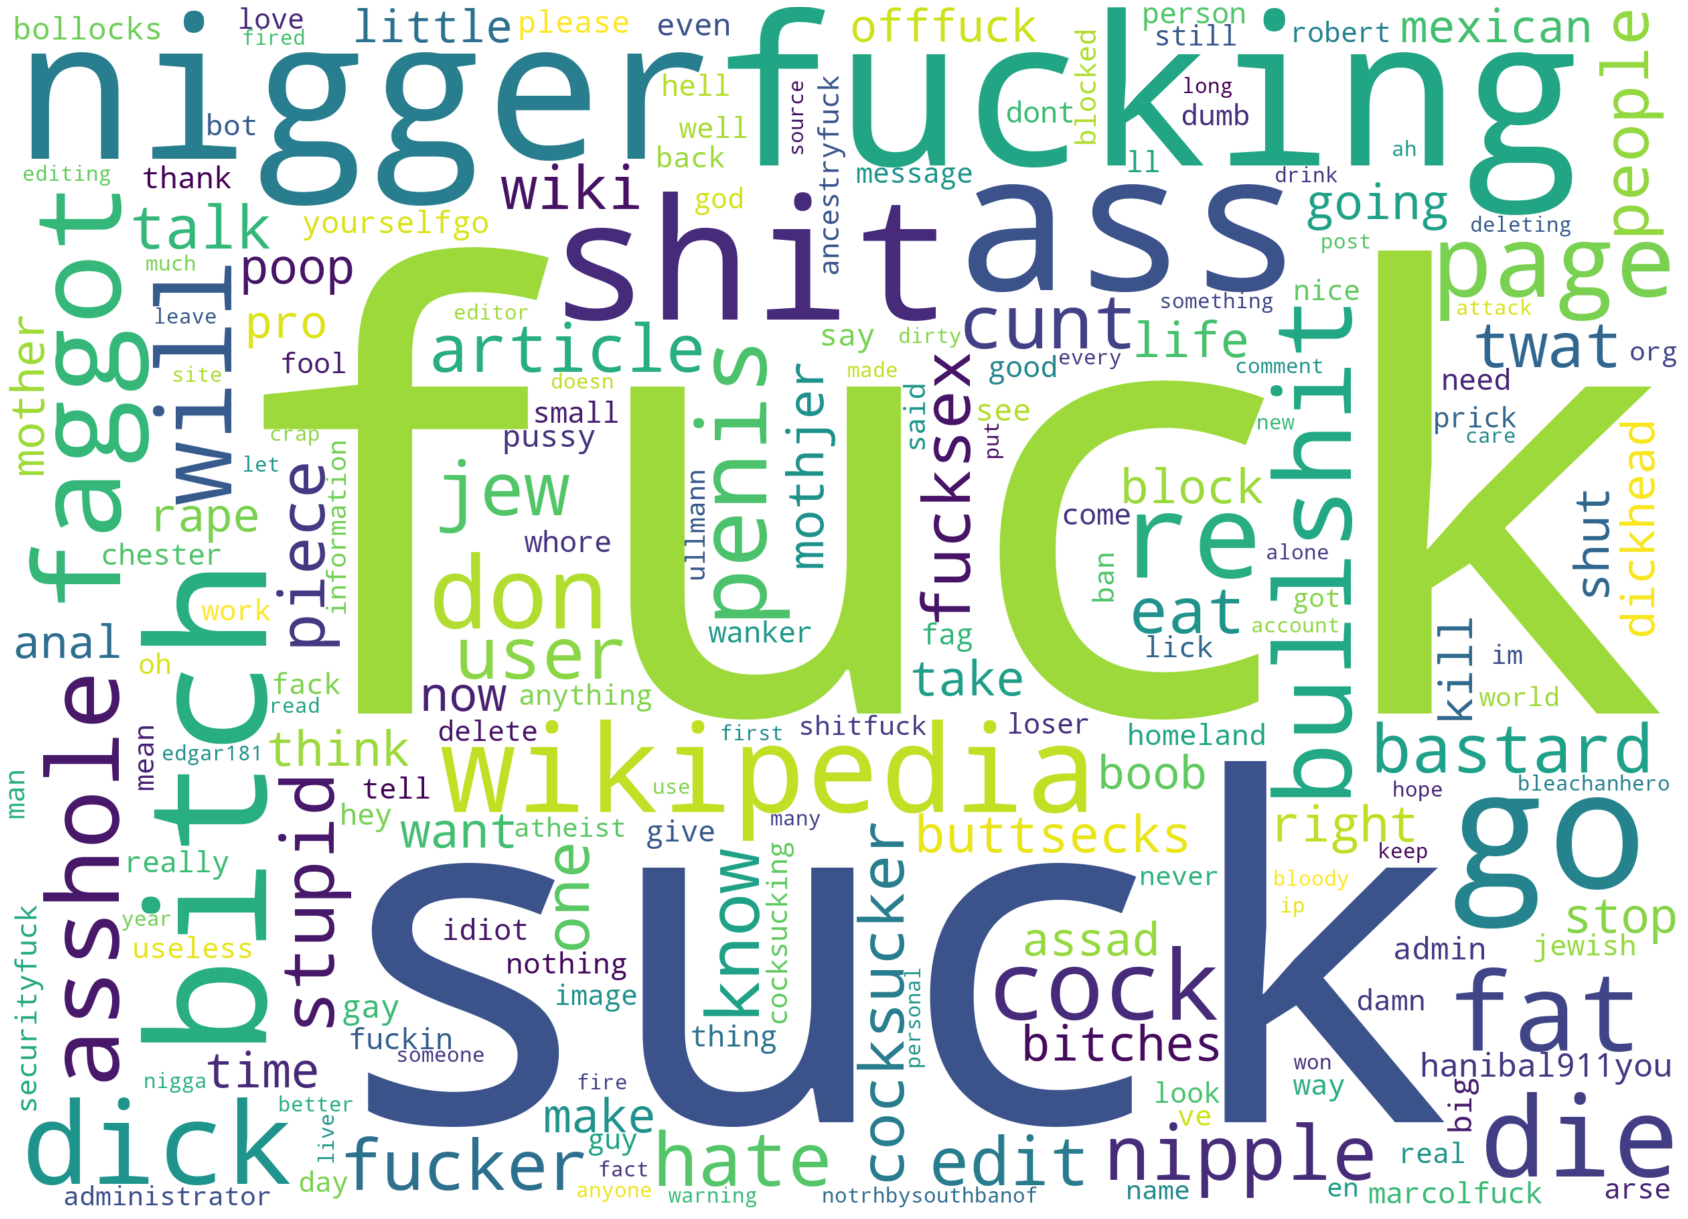

In [71]:
prepare_text(obscene_comments)

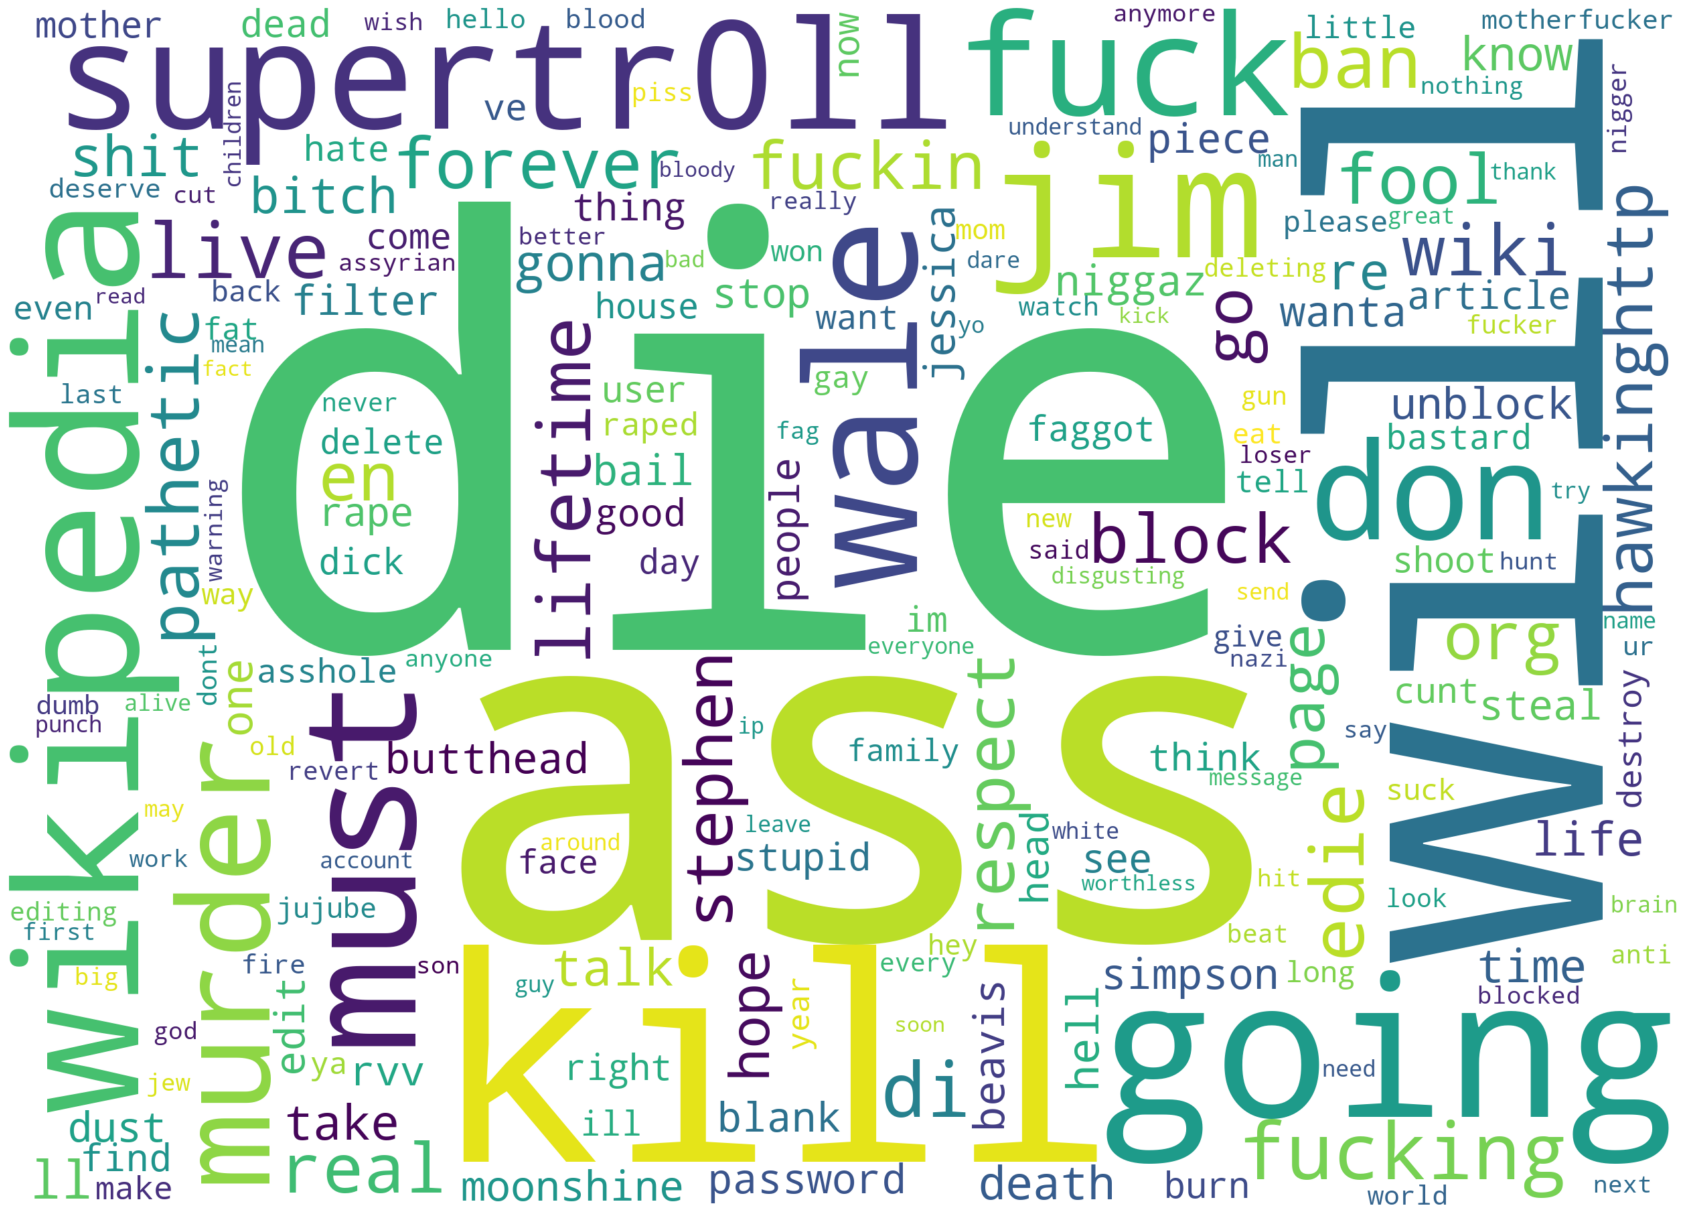

In [72]:
prepare_text(threat_comments)

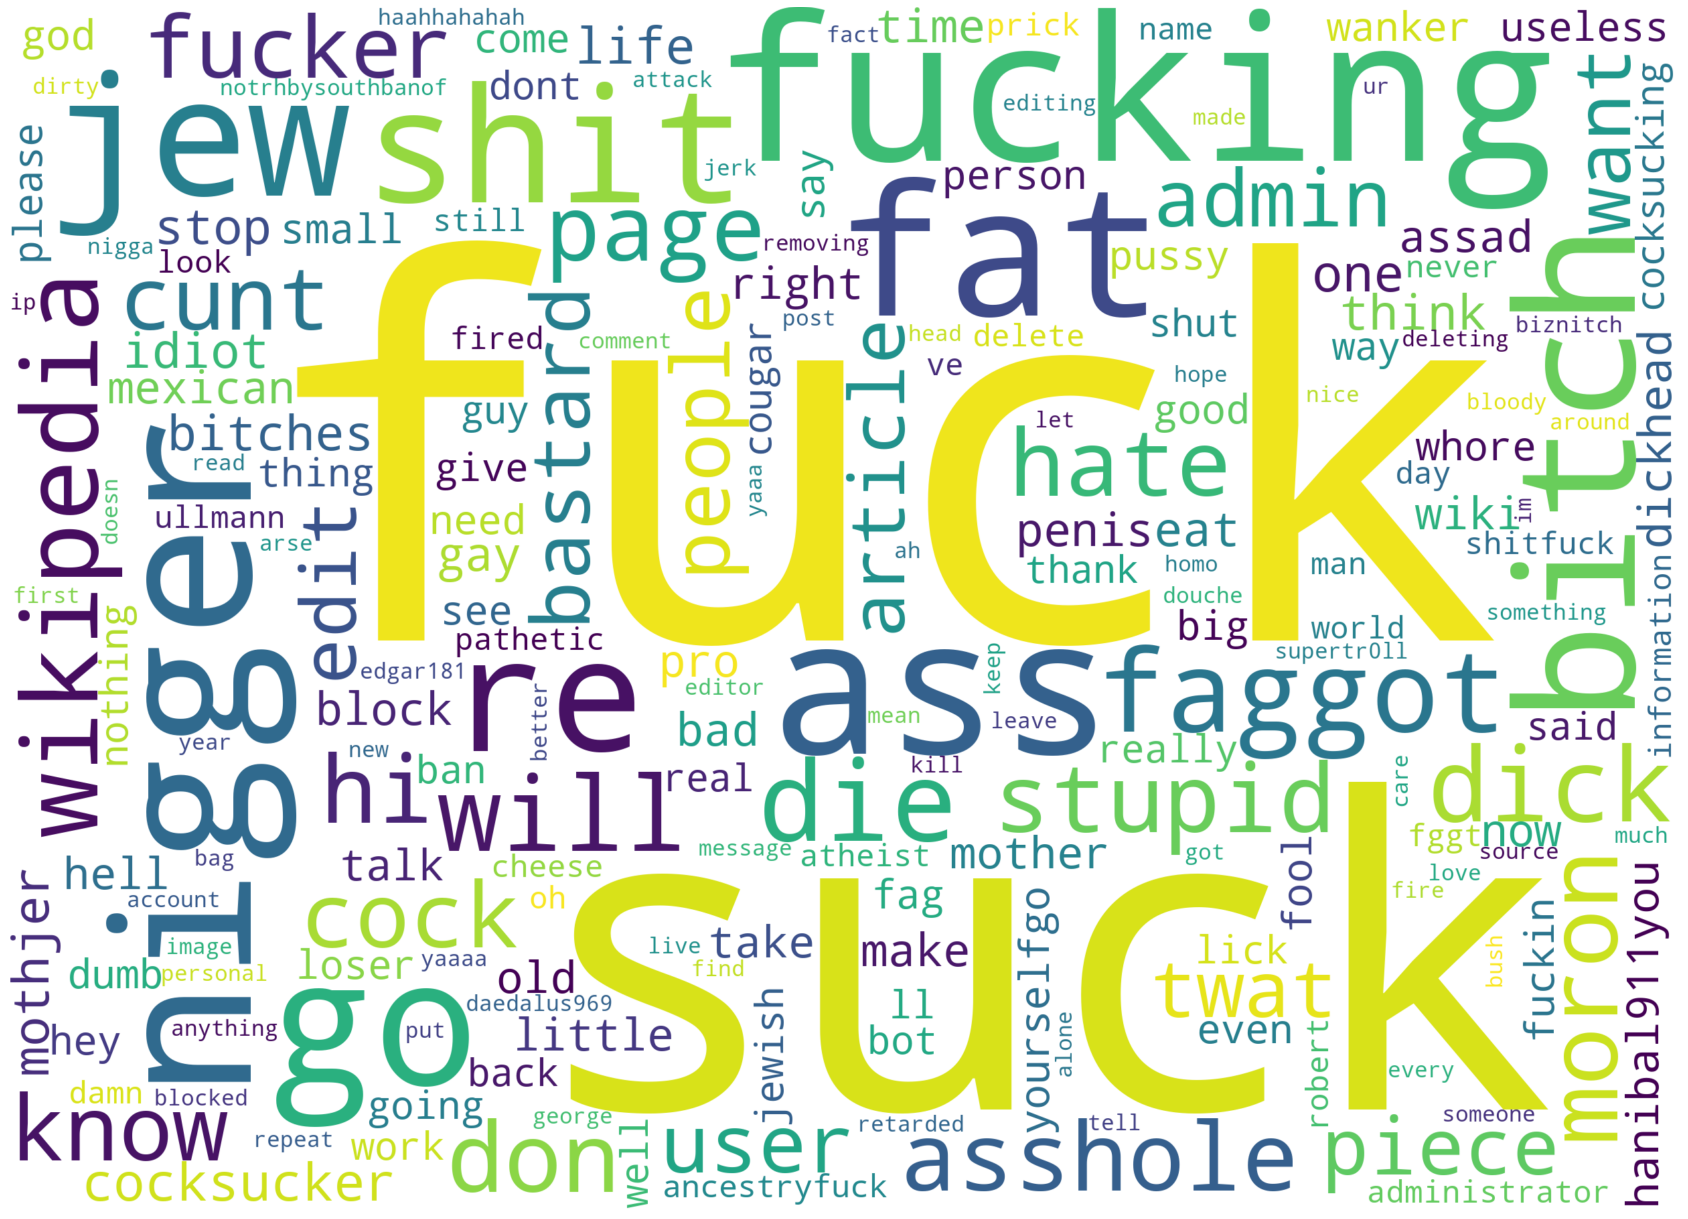

In [73]:
prepare_text(insult_comments)

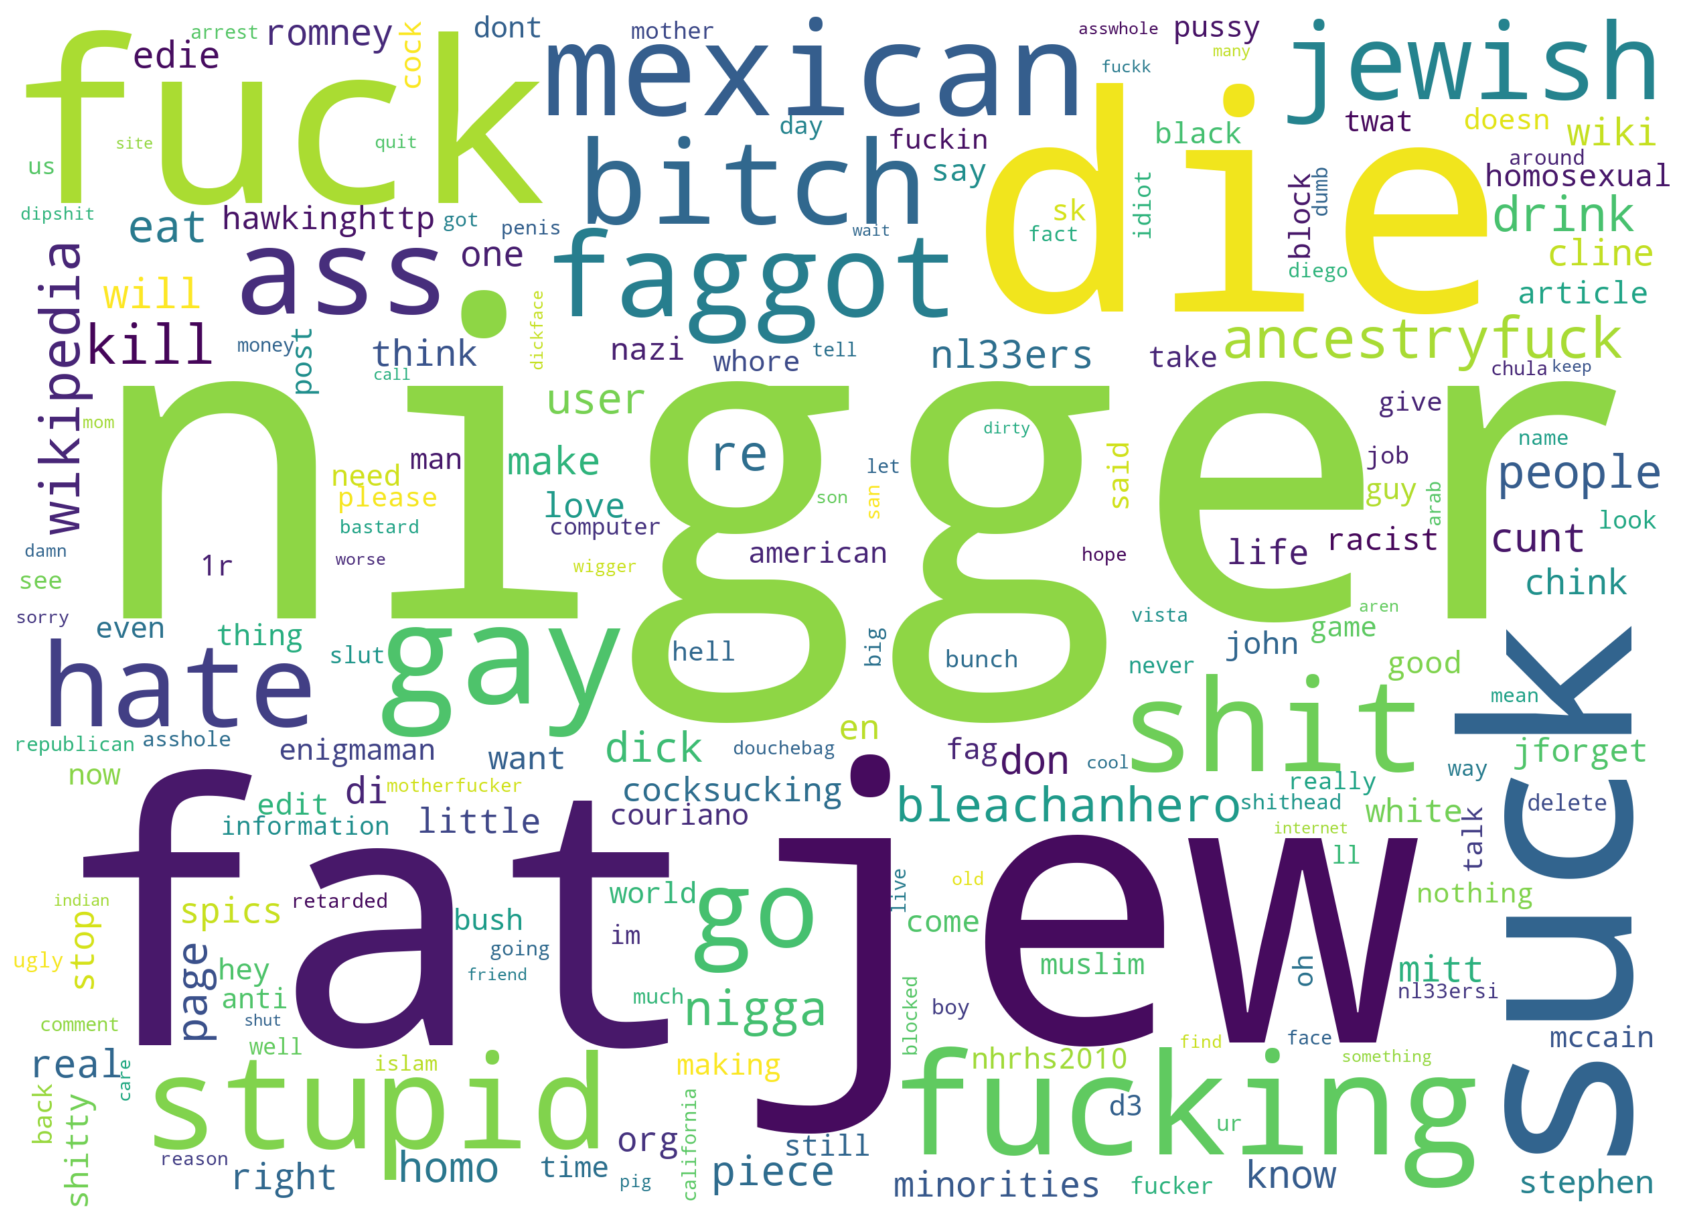

In [74]:
prepare_text(identity_hate_comments)

In [34]:
#creating class_names

scores = []
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [37]:
#applying Logistic model
for classname in class_names:
    train = df_train[classname]
    clf = LogisticRegression(C=2,random_state =2,class_weight = 'balanced')
    cv_score = np.mean(cross_val_score(clf, train_features, train, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    clf.fit(train_features, train)
    submission[classname] = clf.predict_proba(test_features)[:, 1]
    

In [53]:
y=df_train[class_names]

In [63]:
#displaying confusion matrix
for classname in class_names:
    col = df_train[classname]
    print("Column:",col)
    pred =  clf.predict(train_features)
    print('\nConfusion matrix\n',confusion_matrix(col,pred))
    print(classification_report(col,pred))

Column: 0         0
1         0
2         0
3         0
4         0
         ..
111694    0
111695    0
111696    1
111697    0
111698    0
Name: toxic, Length: 111699, dtype: int64

Confusion matrix
 [[100795    233]
 [  8923   1748]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    101028
           1       0.88      0.16      0.28     10671

    accuracy                           0.92    111699
   macro avg       0.90      0.58      0.62    111699
weighted avg       0.92      0.92      0.89    111699

Column: 0         0
1         0
2         0
3         0
4         0
         ..
111694    0
111695    0
111696    0
111697    0
111698    0
Name: severe_toxic, Length: 111699, dtype: int64

Confusion matrix
 [[109018   1551]
 [   700    430]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    110569
           1       0.22      0.38      0.28      1130

    accuracy                  

Column: identity_hate


Text(0.5, 1.0, 'Reciever Operating Characteristic')

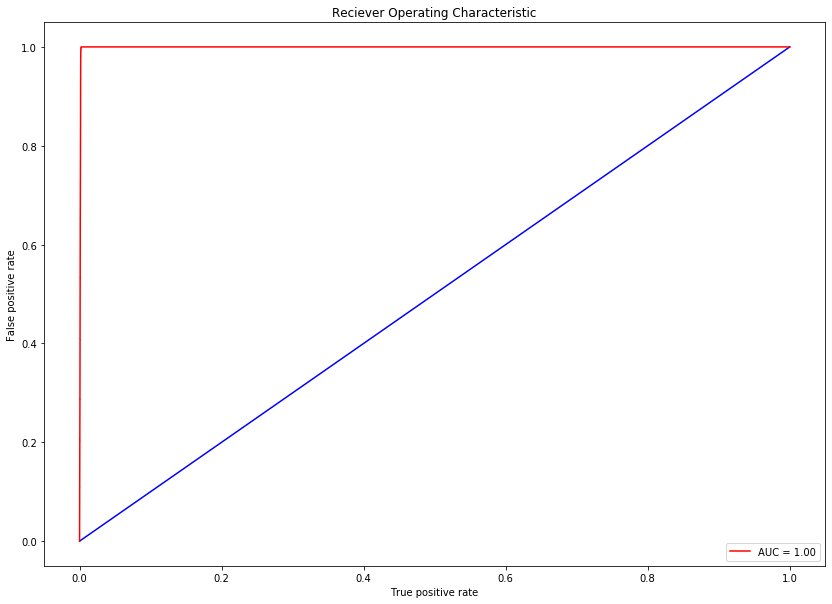

In [49]:
#displaying the ROC curve
col = 'identity_hate'
print("Column:",col)
pred_pro = clf.predict_proba(train_features)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

In [50]:
#accuracy
np.mean(scores)

0.9835276875456801

In [51]:
submission

id     toxic  severe_toxic   obscene    threat    insult  \
0      f88f17ce73d55ad9  0.005001      0.000510  0.004262  0.000187  0.002464   
1      6a9f4af6d51fc9e2  0.104093      0.012501  0.079066  0.002420  0.067227   
2      c44f6d09834d1058  0.045736      0.004621  0.029719  0.009623  0.002982   
3      b1b2e8a5731c75d0  0.828827      0.001639  0.236623  0.004679  0.075013   
4      f25b7274d05d8290  0.040356      0.002112  0.007701  0.006721  0.026788   
...                 ...       ...           ...       ...       ...       ...   
47867  68d02a1d614354a6  0.022918      0.004067  0.001792  0.001420  0.029467   
47868  dadd0dc7778c8660  0.154572      0.017031  0.019171  0.000774  0.058624   
47869  b452dfbbadc6a2a7  0.075808      0.017156  0.006547  0.001519  0.017102   
47870  2cdf622d7b8a413e  0.010488      0.007547  0.009041  0.000758  0.002828   
47871  bd1c7080a727939f  0.136217      0.007632  0.073719  0.003876  0.045635   

       identity_hate  
0           0.000472  
1           0.014595  
2           0.021937  
3           0.014145  
4           0.001188  
...              ...  
47867       0.000369  
47868       0.002862  
47869       0.000422  
47870       0.002051  
47871       0.001248  

[47872 rows x 7 columns]

In [21]:
submission.to_csv('/home/anmol/iiitb-toxic-comment/submission.csv', index=False)

In [ ]:

  
# Save the model as a pickle in a file 
joblib.dump(clf1, 'ML_PROJECT_TOXIC_COMMENT_CLASSIFIER.pkl') 